# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy import sparse, io
from collections import Counter
import os.path
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import pickle
import os
import datetime
import hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import time
# import utils
import seurat_utils
import hyperopt_utils
import utils
# plt.ion()
# plt.show()
# sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()


elbowAnalysis
silhouetteAnalyis
scanpy==1.3.3 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
%load_ext autoreload
import importlib
importlib.reload(seurat_utils)
importlib.reload(hyperopt_utils)
importlib.reload(utils)

scanpy==1.3.3 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
elbowAnalysis
silhouetteAnalyis


<module 'utils' from '../utils.py'>

## Generic method for running bayesian hyperparm optimisation for all datasets

In [5]:
method = 'seurat'


def runSeurat(trialsFile, resultsFile, space, max_evals = 2, restart = True):
    # Define function to optimise
    def evaluateSeurat(args):
        args['cluster_n_neighbors'] = int(args['cluster_n_neighbors'])
        args['cluster_n_pcs'] = int(args['cluster_n_pcs'])

        if args['bpreprocess_min_genes'] == False:
            args['preprocess_min_genes'] = -1
        if args['bpreprocess_min_cells'] == False:
            args['preprocess_min_cells'] = -1
        if args['bpreprocess_teta_total_features'] == False:
            args['preprocess_teta_total_features'] = -1
        if args['bpreprocess_filter_min_mean'] == False:
            args['preprocess_filter_min_mean'] = -1
        if args['bpreprocess_filter_min_disp'] == False:
            args['preprocess_filter_min_disp'] = -1

        if args['preprocess_teta_total_features'] is not None:
            args['preprocess_teta_total_features'] = int(args['preprocess_teta_total_features'])
        try:
            resultDict = seurat_utils.run(args)
            if os.path.isfile(resultsFile):
                results = pd.read_pickle(resultsFile)

                newDf = pd.DataFrame.from_dict(resultDict, orient='index').T
                results = results.append(newDf)

            else:

                results = pd.DataFrame.from_dict(resultDict, orient='index').T
            results.to_pickle(resultsFile)
        except:
            return { 'status' : hyperopt.STATUS_FAIL}

        print(f'>> Result: {resultDict["_rand_index"]}')
        ret = {
            'loss' : -resultDict['_rand_index']
            ,'status' : STATUS_OK
            ,'eval_time' : time.time()        
        }
        return ret

    trials = hyperopt_utils.getTrials(trialsFile ,restart = restart )
    evals_per_epoch = 10
    for e in range(len(trials), max_evals, evals_per_epoch):
        best = fmin(evaluateSeurat
                    ,space
                    ,algo=tpe.suggest 
                    ,max_evals= e + evals_per_epoch
                    ,trials=trials)
        print('Index ', e)
        pickle.dump(trials, open(trialsFile, 'wb'))
    return trials


# BrainCIDR

Run it once with all default parameters to get the parameter range

In [ ]:
params = {}
params['load_inputDataset'] = 'brainCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = 8000
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params)

### Hyperopt input

In [ ]:
dataset = 'brainCIDR'

trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl' 
space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 5000, 15000, 1000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}



In [ ]:
trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))

In [ ]:
utils.plotCorrelation(resultsDf, name=dataset)

# PancreaticIsletCIDR

Run it once with all default parameters to get the parameter range

In [ ]:
params = {}
params['load_inputDataset'] = 'pancreaticIsletCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

### Hyperopt input

In [ ]:

dataset = 'pancreaticIsletCIDR'

trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl'

space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 45000, 60000, 2000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}


In [ ]:
trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

# Deng

Run it once with all default parameters to get the parameter range

In [ ]:
params = {}
params['load_inputDataset'] = 'deng'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']=None
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = False

params['evaluate_plot_results'] = True
seurat_utils.run(params)

### Hyperopt input

In [ ]:
dataset = 'deng'

trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl'

space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 10000, 15000, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}



In [ ]:
trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce10x_qc

In [ ]:
dataset = 'sce10x_qc'
trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl'

params = {}
params['load_inputDataset'] = dataset
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

In [ ]:
space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 9000, 11500, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce2_qc

In [ ]:
dataset = 'sce2_qc'

trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl'

params = {}
params['load_inputDataset'] = dataset
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

In [ ]:
space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 6000, 11000, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce8_qc

... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells


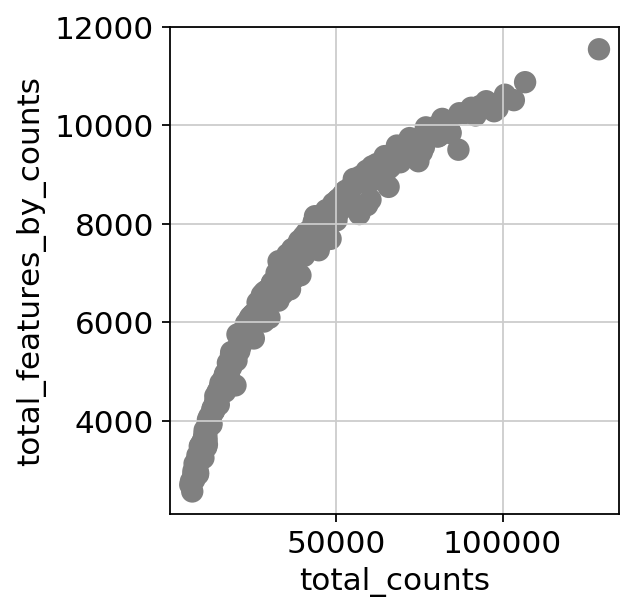

Filtering Counter({False: 11500, True: 4071})


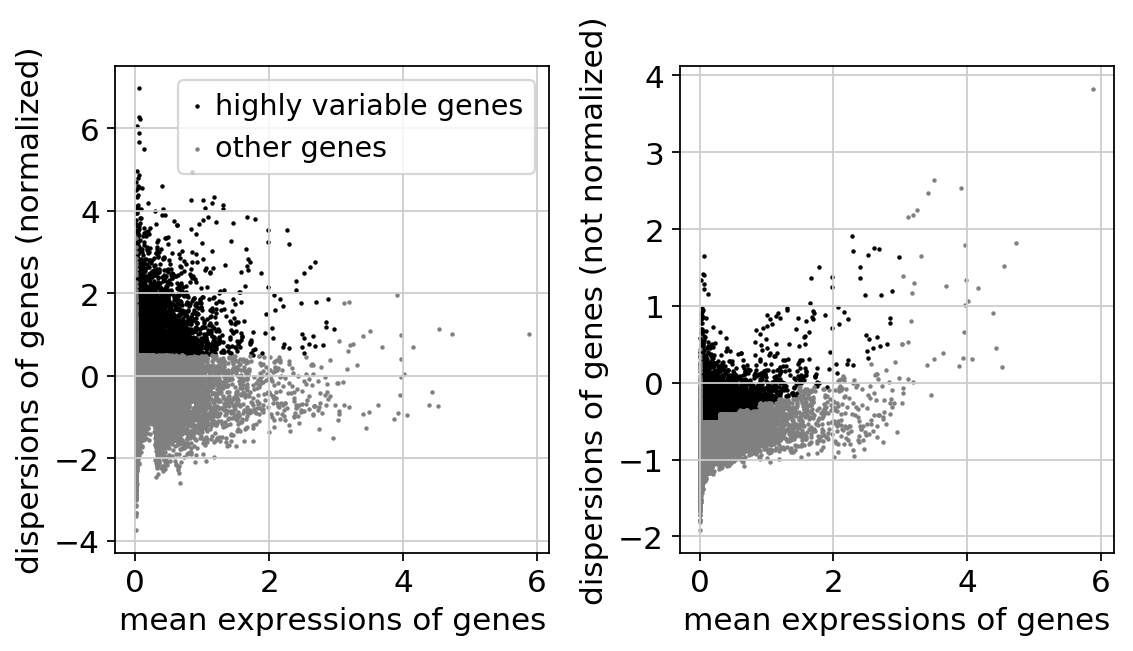

Keeping 4071 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.42)


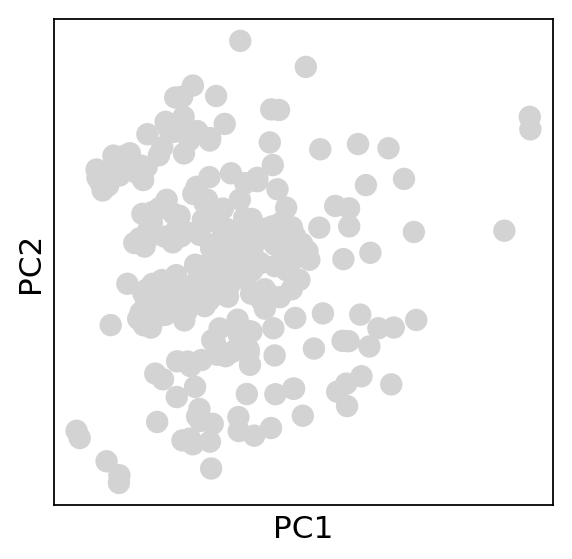

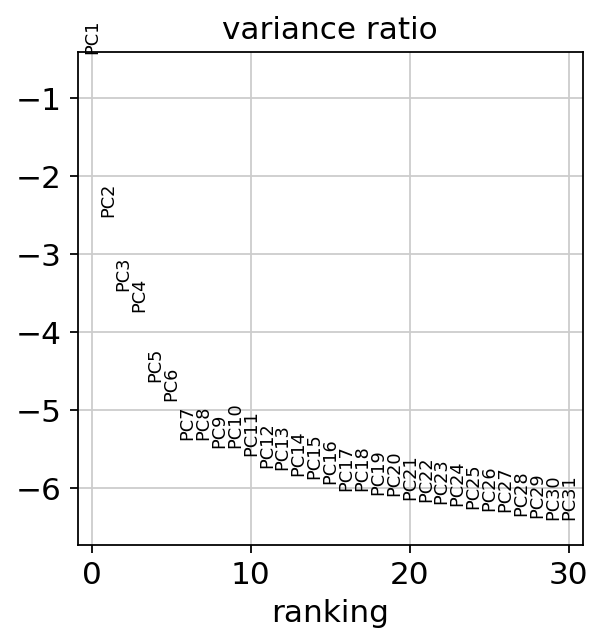

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:01.86) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [6]:
dataset = 'sce8_qc'

trialsFile = f'{dataset}_{method}_trials.pkl'
resultsFile = f'{dataset}_{method}_results.pkl'

params = {}
params['load_inputDataset'] = dataset
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

In [ ]:
space = {
    'load_inputDataset' : dataset
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 8000, 12000, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

trials = runSeurat(trialsFile, resultsFile, space, max_evals = 500);

Creating new trials...
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06713755832528419
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.18) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.09512895784277192
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.75)
computing neighbors
    using 'X_pca' with n_pcs = 22
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.07949074545419767
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:02.60)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.49) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.03705199027500988
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.40)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.56) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.38773675932977025
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 22
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.07146700212801949
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.63)
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5295129488685464
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.81)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.53) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.4924635128353041
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.69)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.03016937589651892
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7526525327709738
Index  0
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.31) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.0682906624857144
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.71)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.26) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7496082803883133
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.91)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06483064500669672
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.20) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.25617229993853563
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:02.23)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.49) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.03705199027500988
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.15)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06339557576206205
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.22) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.09469794322881496
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.80)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06748087758442461
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.22) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.09717623569877393
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06627354686841877
Index  10


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 25
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6777158987578583
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.68)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7667136977671424
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 48
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.736775365088895
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.75)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7834498808858655
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.93)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7813113720420172
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1597 genes that are detected in less than 18.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.79)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.772204302329528
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.71)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 31 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


>> Result: 0.329379258758879
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.95)
computing neighbors
    using 'X_pca' with n_pcs = 48
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.31) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7413506992878738
Index  20
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.79)
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.25296492169092705
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.41)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7896483639262627
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.61)
computing neighbors
    using 'X_pca' with n_pcs = 27
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7955014337042625
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.74)
computing neighbors
    using 'X_pca' with n_pcs = 27
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.52) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7636407012620211
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.82)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2221835635140679
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.00)
computing neighbors
    using 'X_pca' with n_pcs = 26
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.52) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7636407012620211
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.63)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7972269378094113
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:13.54)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.053370782586050845
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.15)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8250574080014679
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.11)
computing neighbors
    using 'X_pca' with n_pcs = 22
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5165513276484727
Index  30


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.36)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7725736036815741
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:13.36)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.043435977461171546
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.50)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8073205075394232
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.51)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.49) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.05487002160096946


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10.26)
computing neighbors
    using 'X_pca' with n_pcs = 44
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.57) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.1881525592798934


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.85)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7945781963160752


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.66)
computing neighbors
    using 'X_pca' with n_pcs = 47
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.07111641720795929
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.04)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.51) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7674660291718771
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.60)
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.043194648762794094
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.18749996514614073
Index  40
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.18)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06017609068831496
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7438476408186195
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:13.17)
computing neighbors
    using 'X_pca' with n_pcs = 23
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.52) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2201759743728413
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.71)
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06310420039812699


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6678205542457049
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.64)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7565067639618095
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:02.83)
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22254436008118908
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 46
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.49) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.02958371421123761
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.61)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8282051402729587
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8163129881563972
Index  50


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06702793707796925
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:11.82)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2577114628441257
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.64)
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6149525836122727
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 26
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6306652823800383
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.10)
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8281478823000985
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.69)
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8281478823000985
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.15)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8281478823000985
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.77)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8281478823000985
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.41)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8329849629875238
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1523 genes that are detected in less than 17.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.97)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.30) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7770646979392521
Index  60
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.15)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8136549307874605
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.29)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.21) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7010261983702127
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.97)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8023969847923275
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1523 genes that are detected in less than 17.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.36)
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.805003100886804
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1597 genes that are detected in less than 18.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.98)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8382190750457329
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1597 genes that are detected in less than 18.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.58)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.26) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8016077109809313
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.69)
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8114224409246952


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.71)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22278753580462726
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.45)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.11) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 75 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


>> Result: 0.06812414855629069
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.36)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7678752752546859
Index  70


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 44
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.15005050593087355
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.81)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8136283063510259
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:02.20)
computing neighbors
    using 'X_pca' with n_pcs = 49
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.23618259566251523
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.97)
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06126776343813821
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.74)
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 33 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


>> Result: 0.30150852133418815
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1523 genes that are detected in less than 17.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.29) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5720855639866254
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:681: RuntimeWarning: invalid value encountered in long_scalars
  n_chunks = np.ceil(adata.X.shape[1] / len_chunk).astype(int)


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.79)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.05177612680672759
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.47)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.49) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7607597906509576


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.30)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5707035358453622
Index  80
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6592181980926145
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.83)
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.19) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2514702655807799
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.30)
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.058626021728337994
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1597 genes that are detected in less than 18.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.82)
computing neighbors
    using 'X_pca' with n_pcs = 46
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.4887603593024338


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.723387918061084


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.12)
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.15033485792154722


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.48)
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.05841317728729695


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.67)
computing neighbors
    using 'X_pca' with n_pcs = 44
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.30) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8098560535900721
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.29)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.544714223493316


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.699656840714169
Index  90


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.66)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2317071353368116


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.82)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.043435977461171546
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.22)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7903432014863164


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.28)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6163156761070416
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7226235550947507


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.75)
computing neighbors
    using 'X_pca' with n_pcs = 27
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.21) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6605642608518434
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.70)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.29) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.23164045923922058


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.68)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06571464763410304


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.76)
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5826607046708602


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6670202734202917
Index  100


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.64)
computing neighbors
    using 'X_pca' with n_pcs = 25
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7704278597374582
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.27)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22021195060291357
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.41)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.07144517268676046
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.10)
computing neighbors
    using 'X_pca' with n_pcs = 42
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6056999834327876


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6789668705733859
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.68)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.30) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8054307324727831


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1411 genes that are detected in less than 16.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.43)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.45) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.23062439541737728


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1790 genes that are detected in less than 20.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.73)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.08289697218687529


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.64)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5872575389330393


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 37 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


>> Result: 0.3080438659339332
Index  110
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.69)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:02.99)
computing neighbors
    using 'X_pca' with n_pcs = 44
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.21859113831953442
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1597 genes that are detected in less than 18.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.97)
computing neighbors
    using 'X_pca' with n_pcs = 47
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06152942181164863


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.88)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6326146475739689


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.53) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7193320220499386


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.75)
computing neighbors
    using 'X_pca' with n_pcs = 26
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8096879080027298


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:13.72)
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22069758641109952


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.25)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06571464763410304


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.31)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.30) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.5047432055417763
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1100 genes that are detected in less than 13.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.57) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7380242275090227
Index  120


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.68)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8114056161299451


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.18)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22596907667730232


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1523 genes that are detected in less than 17.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.10)
computing neighbors
    using 'X_pca' with n_pcs = 46
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06205425252546472


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.13)
computing neighbors
    using 'X_pca' with n_pcs = 23
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.6154041611996609


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.713157694968996


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.82)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.26) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7980519720274385


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 214 genes that are detected in less than 7.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.99)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.2286474404871674


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.71)
computing neighbors
    using 'X_pca' with n_pcs = 49
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06483064500669672


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.72)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1206 genes that are detected in less than 14.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7170739458675529
Index  130


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.72)
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7588011377740996


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1301 genes that are detected in less than 15.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.46)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.22856203431479818
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 1705 genes that are detected in less than 19.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.93)
computing neighbors
    using 'X_pca' with n_pcs = 31
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.06377910161677873


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 401 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.32)
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.09) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.55) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7725736036815741


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 583 genes that are detected in less than 9.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.19647090043141424
... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.90)
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8281478823000985


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 884 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.79)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.52) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.7607597906509576


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 987 genes that are detected in less than 12.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.50)
computing neighbors
    using 'X_pca' with n_pcs = 34
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
>> Result: 0.8179795847765277


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


... reading from cache file ./cache/input-cellBench-sce8_qc-matrix.h5ad
Loading dataset sce8_qc with 15571 genes and 296 cells
filtered out 769 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)